# Teaching a car to drive

In this project the objective is to train a convolutional neural network to compute the commanded steering angle for a car using a raw video feed. The training data will be composed of video that a human driver produces with the current steering angle assigned to each frame.

The source for the data will be from a simulator provided by Udacity.

![Udacity Simulator Photo](resources/simulation_image.png)

The simulator has two modes, training and autonomous. In training mode I am able to drive the car using my keyboard and mouse to record training data. In autonomous mode I can supply the simulator with a trained keras model and it will drive at a fixed velocity. 

For validation of the models performance, the simulator has two tracks. The first will be used to train the model and the second will be used to test the models ability to generalize.

## Image Analysis and Augmentation Strategy

The data that is returned from the simulator emulates having three offset front facing cameras that are time synchronized. This gives a left, center, and right perspective. The reason this is done is to extend the dataset. The two offset perspectives give two additional angles of sharper turns. Using a fixed steering angle offset this has the effect of training the car to drive to the center of the road.

To increase the utility of the dataset image augmentations will be performed. The augmentations that will be used are horizontal shifts and rotations. These will make the car robust to inherent offsets between the cameras. In addition to this a horizontal flip will be randomly applied to effectively train the car on the opposite type of turn.

Using TensorFlow backend.


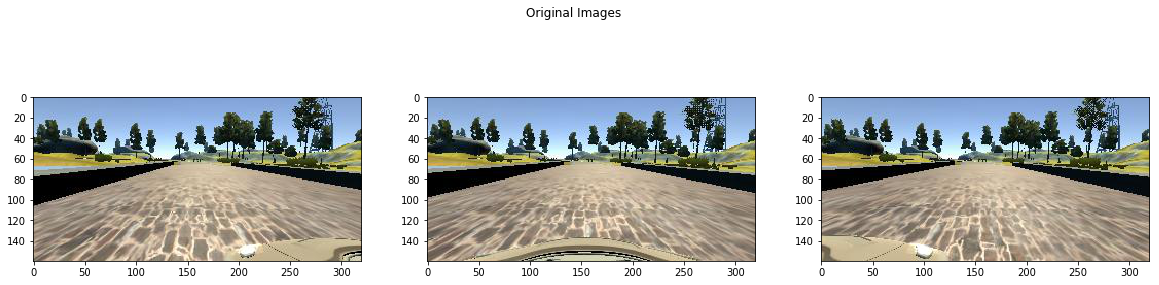

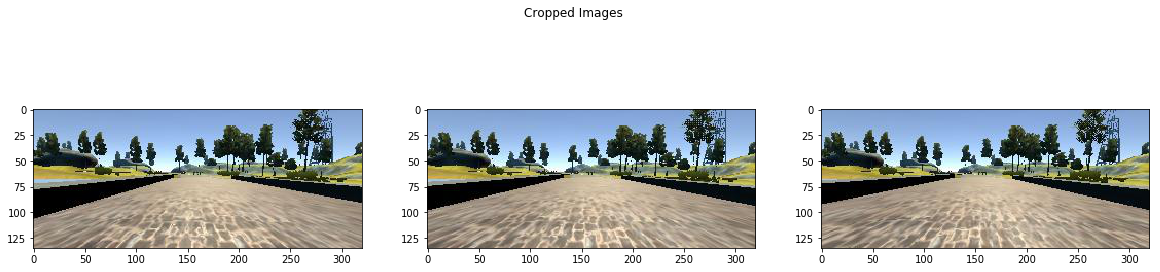

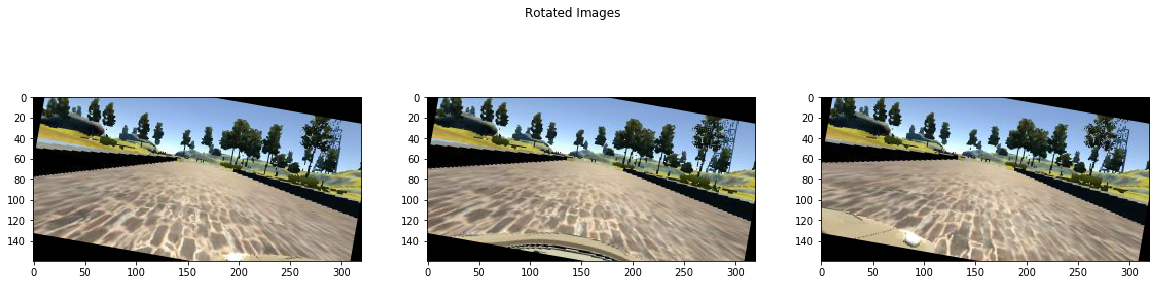

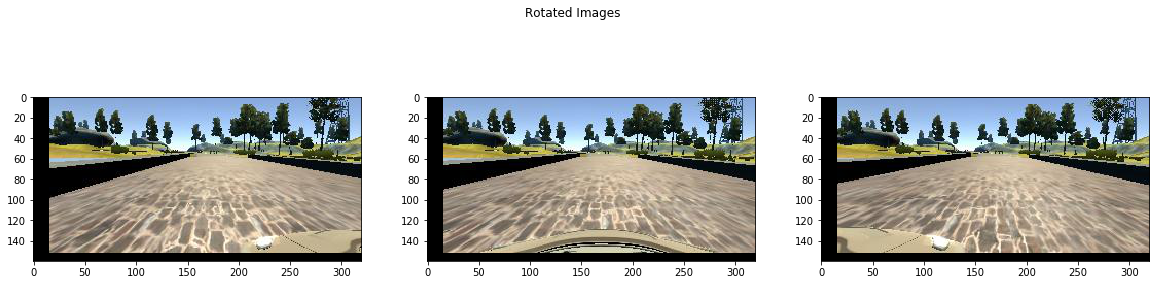

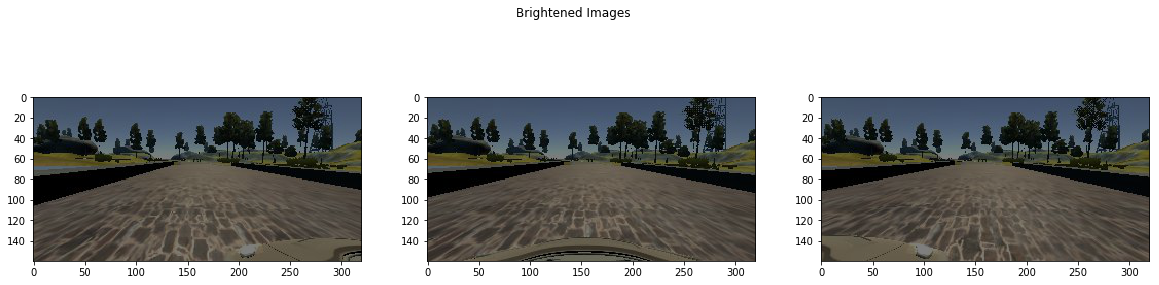

In [2]:
import imp
import matplotlib.pyplot as plt
import steering_model
imp.reload(steering_model)

plt.close("all")

# plot example entry from training set
images = steering_model.random_entry()
fig, axes = plt.subplots(1, 3, figsize=(20,5))
fig.suptitle("Original Images")
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.show()

# crop car out of image
fig, axes = plt.subplots(1, 3, figsize=(20,5))
fig.suptitle("Cropped Images")
for img, ax in zip(images, axes):
    ax.imshow(steering_model.crop(img, height=25))
plt.show()

# shift images
fig, axes = plt.subplots(1, 3, figsize=(20,5))
fig.suptitle("Rotated Images")
for img, ax in zip(images, axes):
    ax.imshow(steering_model.shift(img, wrg=0.05, hrg=-0.05))
plt.show()

# brightness
fig, axes = plt.subplots(1, 3, figsize=(20,5))
fig.suptitle("Brightened Images")
for img, ax in zip(images, axes):
    ax.imshow(steering_model.brightness(img, scale=0.5))
plt.show()

## Random Horizontal Flip

This will provide training examples that emulate turning right even though the track is composed almost entirely of left hand turns.

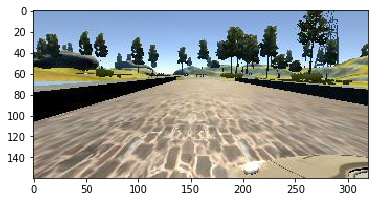

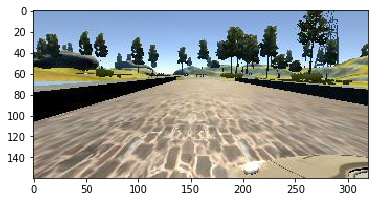

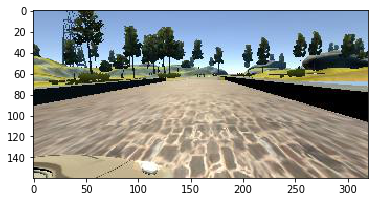

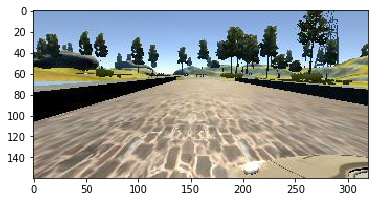

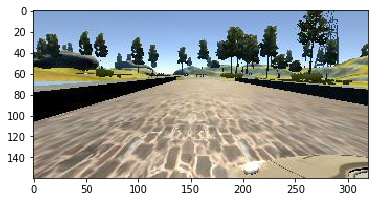

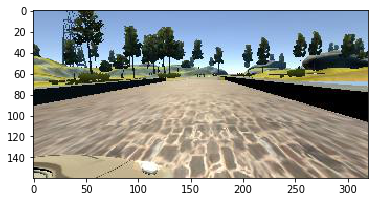

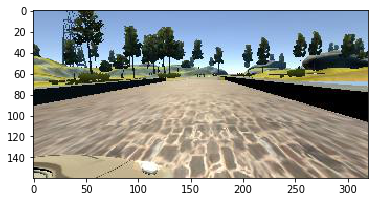

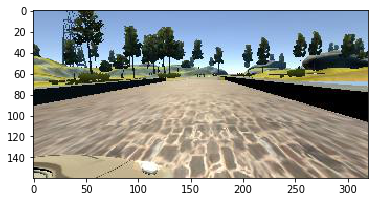

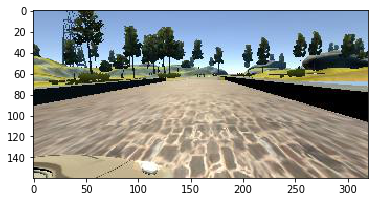

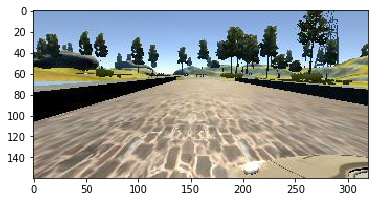

In [3]:
imp.reload(steering_model)
plt.close("all")
for i in range(10):
    plt.imshow(steering_model.random_flip(images[0]))
    plt.show()

## Random Shift

Randomly shift the image both vertically and horizontally with respect to the image height and width.

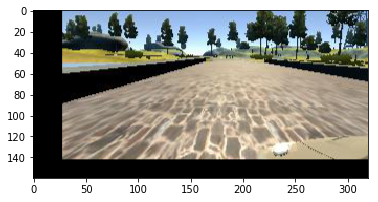

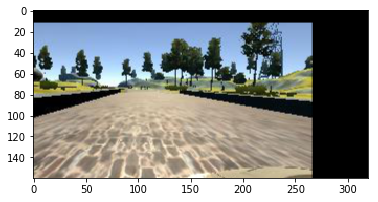

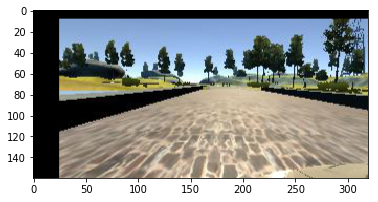

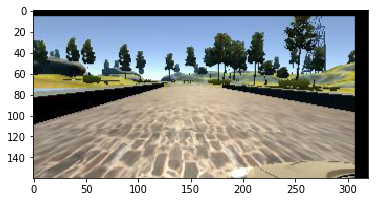

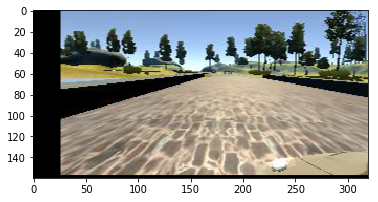

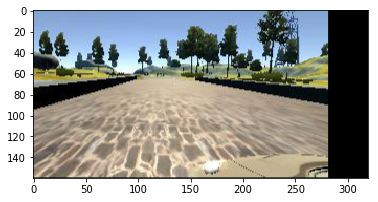

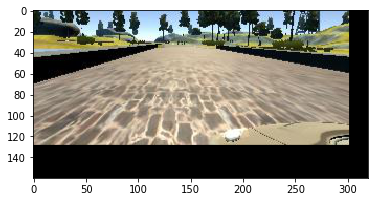

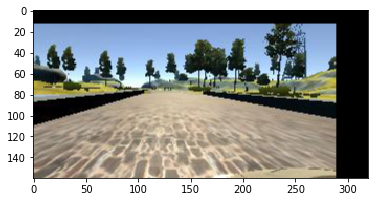

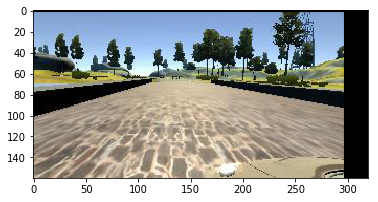

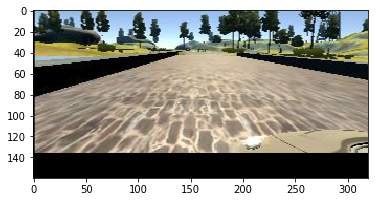

In [4]:
imp.reload(steering_model)
plt.close("all")
for i in range(10):
    plt.imshow(steering_model.random_shift(images[0], 0.2, 0.2))
    plt.show()

## Random Brightness

Lighting conditions can change depending on your environment. This augmentation is designed to make the model more robust to changes in lighting conditions.

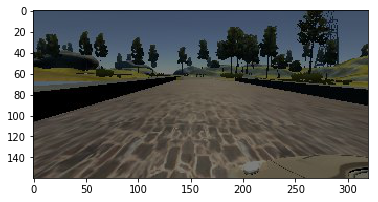

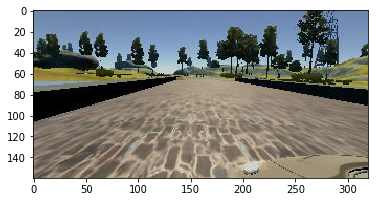

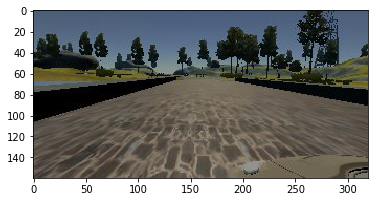

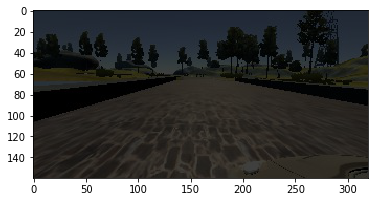

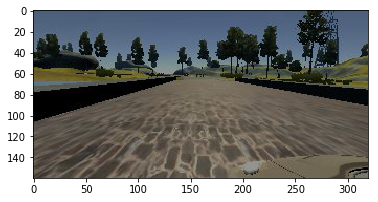

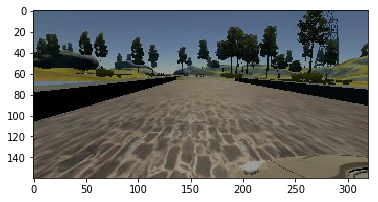

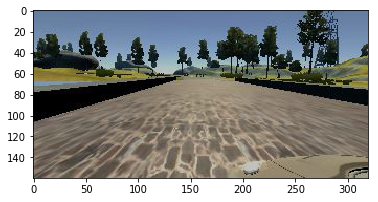

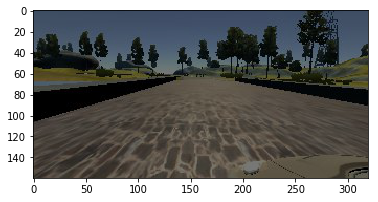

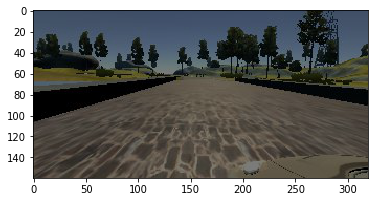

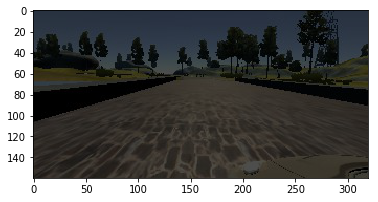

In [6]:
imp.reload(steering_model)
plt.close("all")
for i in range(10):
    plt.imshow(steering_model.random_brightness(images[0]))
    plt.show()

## Image Generator

The image generator is responsible for supplying batches of augmented and preprocessed images to the model for training.

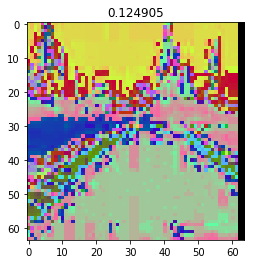

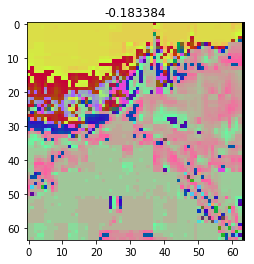

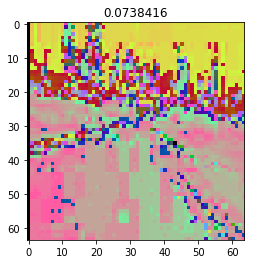

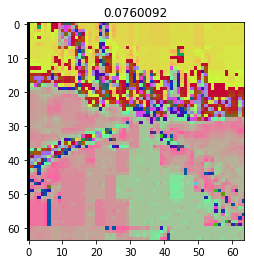

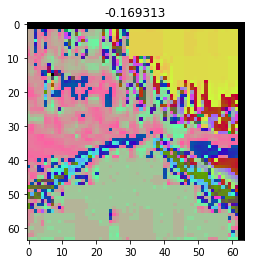

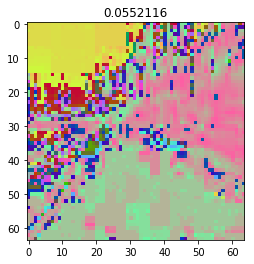

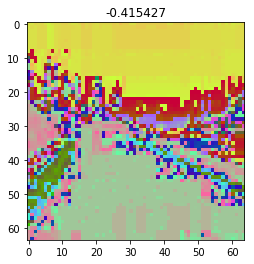

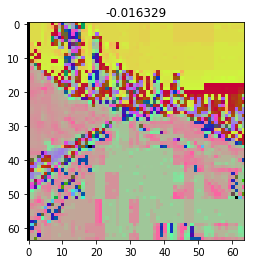

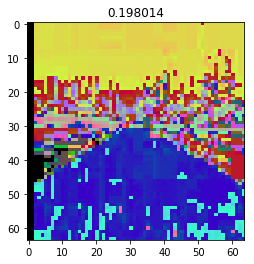

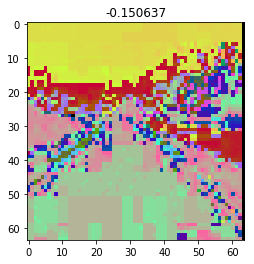

In [37]:
imp.reload(steering_model)
gen = steering_model.image_generator(fp='driving_log.csv', batch_size=10, train=True)
for images, angles in gen:
    for img, angle in zip(images, angles):
        plt.imshow(img)
        plt.title(angle)
        plt.show()
    break

## Generate Datasets

The original dataset has a lot of straight line driving in it. If we were to train using that dataset the model will be biased towards the straight line driving angle. To counter act this multiple datasets will be created that contain varying ratios of high angle images and straight images.

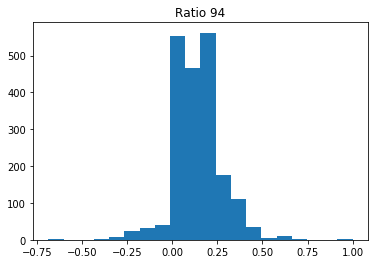

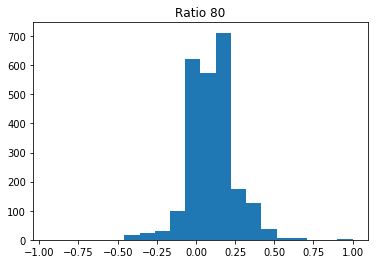

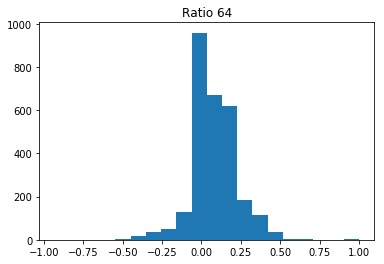

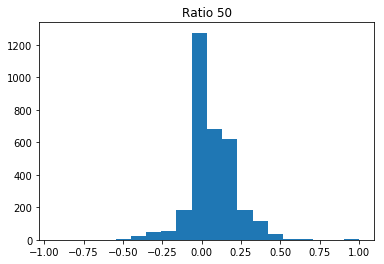

In [120]:
threshold = 0.05

for x in [0.25, 0.5, 0.75, 1]:    
    ds = pd.read_csv('data/original.csv', names=['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed'])

    high_selection, = np.where(ds.steering > threshold)

    a = len(high_selection)
    b = len(high_selection) * x

    low_selection, = np.where(ds.steering <= threshold)
    low_index = np.random.randint(0, len(low_selection), size=(int(b),))
    low_selection = low_selection[low_index]

    selection = np.concatenate((high_selection, low_selection))

    ratio = np.round(int(a / (a + b * x) * 100))

    ds = ds.iloc[selection]

    fp = "data/original_ratio_{}_thresh_{}.csv".format(ratio, str(threshold).replace('.', '_'))
    ds.to_csv(path_or_buf=fp, index=False, header=False)
    
    plt.title("Ratio {}".format(ratio))
    plt.hist(ds.steering, bins=20)
    plt.show()

In [135]:
import os
import re

MODEL_NAME_REG = re.compile("(?P<current>\d*)_(?P<prior>\d*)_(?P<data_src>.*)_(?P<epochs>\d*)_(?P<steps>\d*)")
match = MODEL_NAME_REG.match("1_0_original_5_400")
current, previous = int(match.group("current")) + 1, match.group("current")
fp = "data/original_ratio_50_thresh_0_05.csv"
data_src = os.path.splitext(os.path.basename(fp))[0]

model_name = "{}_{}__{}__{}_{}.h5".format(current, previous, data_src, 4, 400)
model_name

'2_1__original_ratio_50_thresh_0_05__4_400.h5'

In [ ]:
test = "1_1asdfsjdklfjkls;jfkljsklf"